# EDSA Movie Recommendation 2022

### Honour Code

**I Matthew De Kock**, confirm - by submitting this document - that the solutions in this notebook are a result of my own work and that I abide by the [EDSA honour code](https://drive.google.com/file/d/1QDCjGZJ8-FmJE3bZdIQNwnJyQKPhHZBn/view?usp=sharing).

Non-compliance with the honour code constitutes a material breach of contract.


Aim to predict and build a reccomender engine for movies. Final project of unsupervised learning predict 

# Importing packages

In [36]:
# Libraries for importing and loading data
import numpy as np
import pandas as pd
from nltk.tokenize import word_tokenize, TreebankWordTokenizer
import scipy as sp 
import matplotlib.pyplot as plt
import seaborn as sns
import os
from textwrap import wrap

# Similarty and Featurisation 
from sklearn.metrics.pairwise import cosine_similarity 
from sklearn.feature_extraction.text import TfidfVectorizer
from surprise import SVD
from surprise import Reader, Dataset
from surprise.model_selection import GridSearchCV, cross_validate


# Sorting libraries
import operator 
import heapq 
from time import time

# Setting global constants to ensure notebook results are reproducible

RANDOM_STATE = 42


import warnings
warnings.filterwarnings('ignore')

# Loading the data


In [37]:
# load the data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
genome_scores = pd.read_csv('genome_scores.csv')
genome_tags = pd.read_csv('tags.csv')
imdb_data = pd.read_csv('imdb_data.csv')
links = pd.read_csv('links.csv') 
movies = pd.read_csv('movies.csv')
tags = pd.read_csv('tags.csv')

In [38]:
# Preview train dataset
print('Data shape: ', train.shape)
train.head()

Data shape:  (10000038, 4)


,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


### Checking the shape of the data

In [39]:
print('Data shape: ', test.shape)
test.head()

Data shape:  (14310, 2)


,userId,movieId
0,5,788
1,68,7438
2,336,40412
3,803,3822
4,547,903


In [40]:
print('Data shape: ', tags.shape)
tags.head()

Data shape:  (1093360, 4)


,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455


In [41]:
print('Data shape: ', links.shape)
links.head()

Data shape:  (62423, 3)


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [42]:
print('Data shape: ', movies.shape)
movies.head()

Data shape:  (62423, 3)


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [43]:
print('Data shape: ', imdb_data.shape)
imdb_data.head()

Data shape:  (27278, 6)


,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry
3,4,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,124.0,"$16,000,000",black american|husband wife relationship|betra...
4,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion


In [44]:
print('Data shape: ', genome_tags.shape)
genome_tags.head()

Data shape:  (1093360, 4)


,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455


In [45]:
print('Data shape: ', genome_scores.shape)
genome_scores.head()

Data shape:  (15584448, 3)


,movieId,tagId,relevance
0,1,1,0.02875
1,1,2,0.02375
2,1,3,0.06250
3,1,4,0.07575
4,1,5,0.14075


# EDA

In [46]:
#Making a copy of movies so we don't change our data permanantly. 
movies_table = movies.copy()

movies_table["genres"] = movies_table["genres"].str.replace('|', ' ', regex=True)
movies_table["title"] = movies_table["title"].str.replace('(', ' ', regex=True)
movies_table["title"] = movies_table["title"].str.replace(')', ' ', regex=True)
movies_table["genres"] = movies_table["genres"].str.replace('(', ' ', regex=True)
movies_table["genres"] = movies_table["genres"].str.replace(')', ' ', regex=True)
movies_table["year"] = movies_table["title"].str.replace(r'[a-zA-Z]', '', regex=True)
movies_table["year"] = movies_table["year"].str.replace(r' ', '', regex=True)
movies_table.head()

,movieId,title,genres,year
0,1,Toy Story 1995,Adventure Animation Children Comedy Fantasy,1995
1,2,Jumanji 1995,Adventure Children Fantasy,1995
2,3,Grumpier Old Men 1995,Comedy Romance,1995
3,4,Waiting to Exhale 1995,Comedy Drama Romance,1995
4,5,Father of the Bride Part II 1995,Comedy,1995


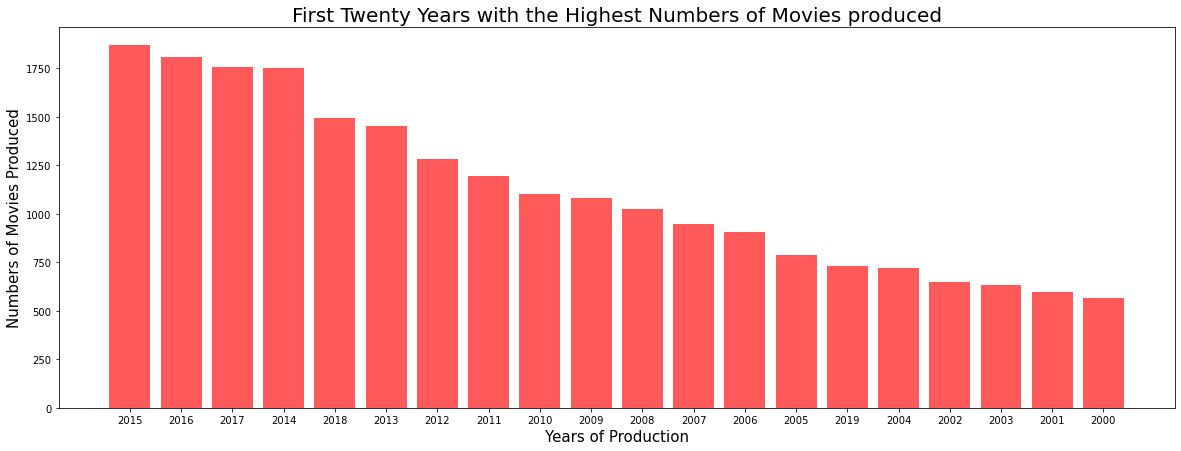

In [47]:
# Visualise the first twenty years with the highest numbers of movies produced
movies_table["year"] = movies_table["year"].astype('str')
movies_year_count = movies_table["year"].value_counts()
fig, ax = plt.subplots( figsize=(20,7))
ax.bar(movies_year_count.index[:20], movies_year_count.values[:20],  facecolor='r', alpha=0.65)
ax.set_xlabel("Years of Production", fontsize = 15)
ax.set_ylabel("Numbers of Movies Produced", fontsize = 15)
ax.set_title("First Twenty Years with the Highest Numbers of Movies produced", fontsize = 20)
plt.show()

In [48]:
def tokenizer(data, col):
    """
        This function takes in a dataframe and a col, creates a new column to store the tokenized words
        in the inputed column, and returns a new dataframe.
    """
    df = data.copy()
    tokeniser = TreebankWordTokenizer()
    df['genre_tok'] = df[col].apply(tokeniser.tokenize)
    return df  

In [49]:
#Generes tokenized
movies_table = tokenizer(movies_table, 'genres')
movies_table.head()

,movieId,title,genres,year,genre_tok
0,1,Toy Story 1995,Adventure Animation Children Comedy Fantasy,1995,"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji 1995,Adventure Children Fantasy,1995,"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men 1995,Comedy Romance,1995,"[Comedy, Romance]"
3,4,Waiting to Exhale 1995,Comedy Drama Romance,1995,"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II 1995,Comedy,1995,[Comedy]


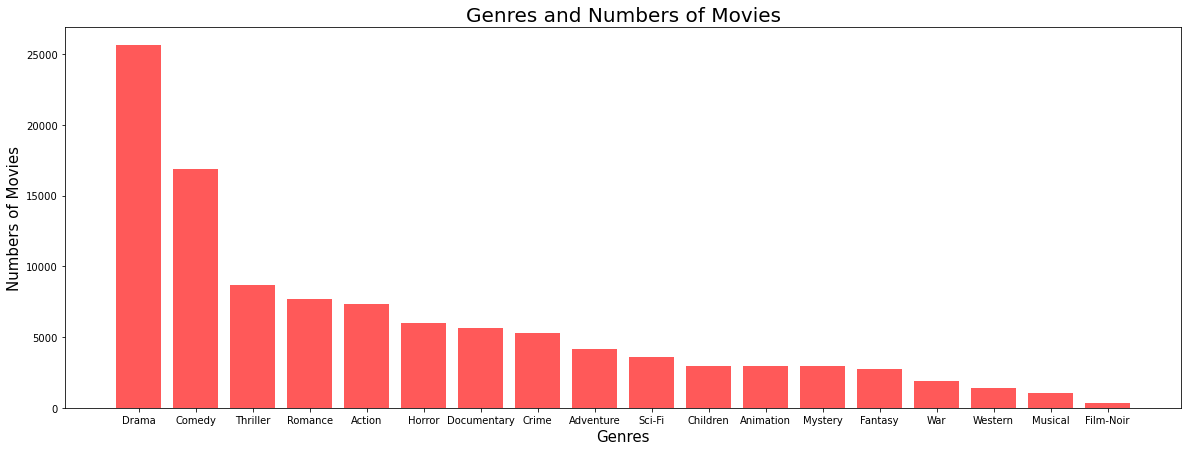

In [50]:
# Collect the tokenized genre in a list form
genres = movies_table['genre_tok'].values.tolist()
all_genres = []
for index, genre in enumerate(genres):
    all_genres.extend(genre)

genre_df = pd.DataFrame({
    "genre":all_genres
})

genre_df = genre_df[genre_df['genre'].isin(['no', 'listed', 'genres', 'IMAX']) == False]
genre_count = genre_df["genre"].value_counts()
fig, ax = plt.subplots( figsize=(20,7))
ax.bar(genre_count.index, genre_count.values,  facecolor='r', alpha=0.65)
ax.set_xlabel("Genres", fontsize = 15)
ax.set_ylabel("Numbers of Movies", fontsize = 15)
ax.set_title("Genres and Numbers of Movies", fontsize = 20)
plt.show()

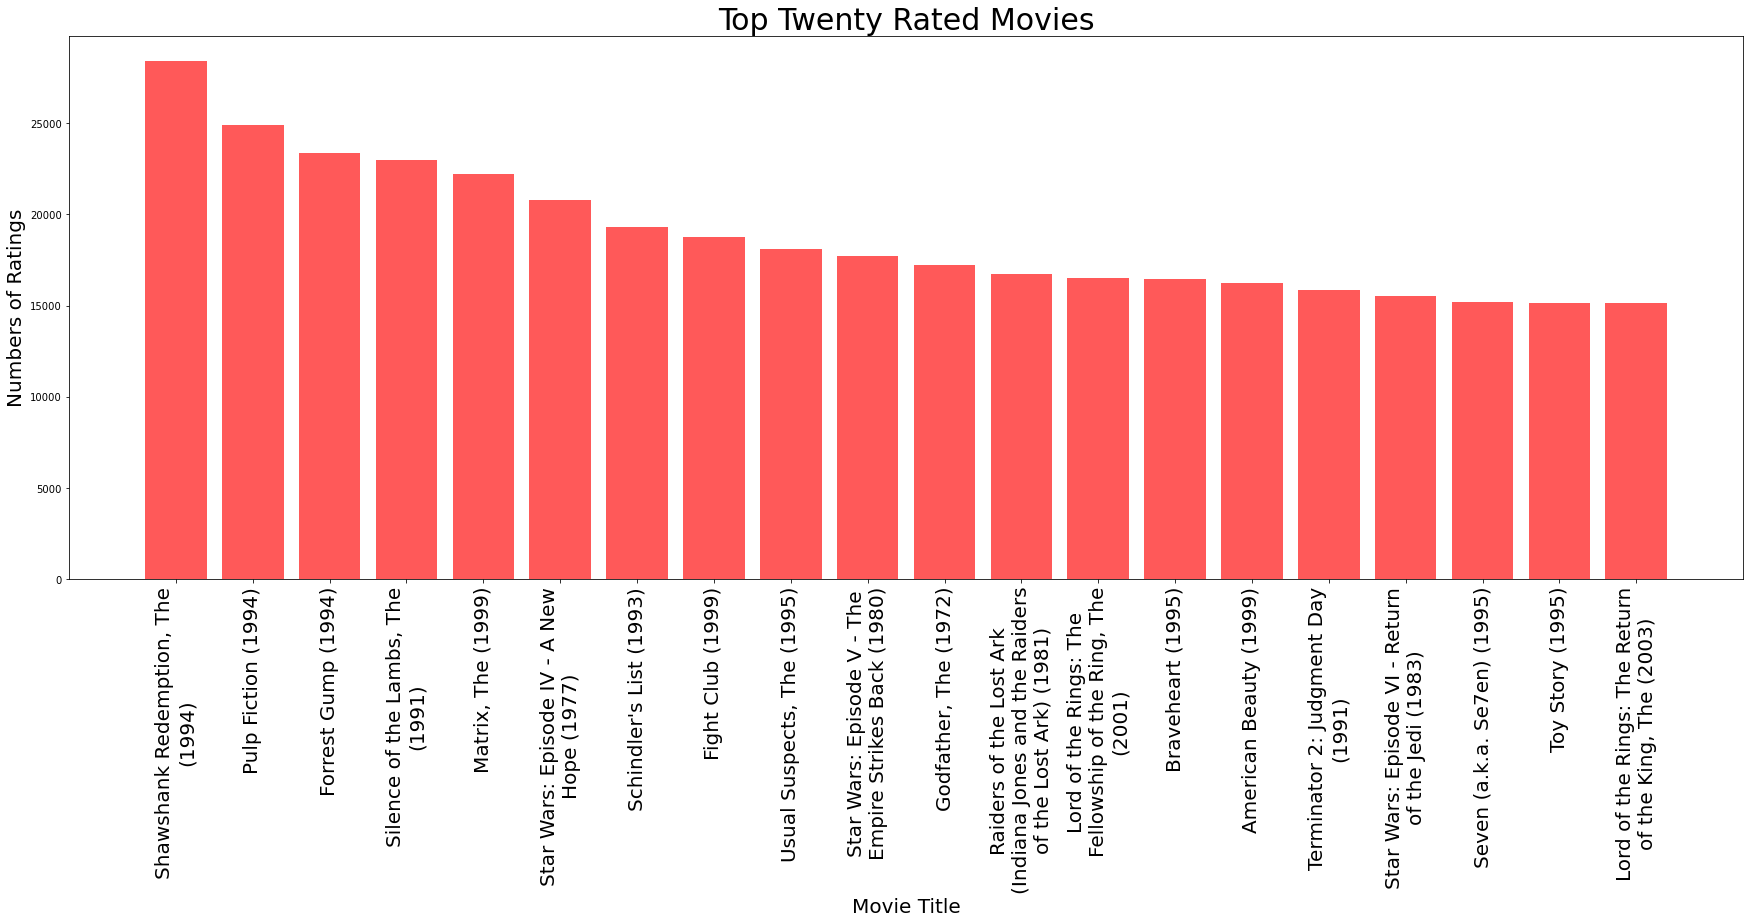

In [51]:
train_table = train.copy()
train_table.drop(columns='timestamp', inplace=True)
ratings = train_table[['movieId','rating']]
ratings = ratings[ratings['rating'] > 3.9]
ratings = ratings.merge(movies, on = 'movieId', how= 'left')
movies_ratings = ratings['title'].value_counts()

labels = [ '\n'.join(wrap(l, 30)) for l in movies_ratings.index[:20]]



fig, ax = plt.subplots( figsize=(30,10))

ax.bar(labels, movies_ratings.values[:20],  color='r', alpha=0.65, width = 0.8)
ax.set_xlabel("Movie Title", fontsize = 20)
ax.set_ylabel("Numbers of Ratings", fontsize = 20)
ax.set_title("Top Twenty Rated Movies", fontsize = 30)
plt.xticks(rotation=90, fontsize= 20)
plt.show()

# Data engeneering

In [52]:
test['userId'].nunique()

982

In [53]:
test_case = test['userId'].nunique()
train_case = train['userId'].nunique()
print('The difference in unique userID count between train and test data set is:', (train_case - test_case))

The difference in unique userID count between train and test data set is: 161559


In [54]:
test_userids = test['userId'].unique().tolist()
test_userids[:20]

[5,
 68,
 336,
 803,
 547,
 514,
 367,
 345,
 468,
 441,
 30,
 865,
 379,
 754,
 986,
 973,
 860,
 541,
 155,
 166]

In [55]:
useful_train = train.copy()

useful_train.shape

(10000038, 4)

In [56]:
useful_train.sort_values(by=['userId'], inplace= True)
useful_train.head()

,userId,movieId,rating,timestamp
6308822,1,296,5.0,1147880044
3137042,1,27721,3.0,1147869115
2533005,1,665,5.0,1147878820
2524478,1,4308,3.0,1147868534
1946297,1,1250,4.0,1147868414


In [57]:
test.sort_values(by=['userId'], inplace= True)
test.head()

,userId,movieId
13686,1,665
9910,1,7937
538,1,899
8676,1,2632
2257,2,1465


In [58]:
useful_train = useful_train.merge(imdb_data, on = 'movieId', how= 'left')
useful_train.head()

,userId,movieId,rating,timestamp,title_cast,director,runtime,budget,plot_keywords
0,1,296,5.0,1147880044,Tim Roth|Amanda Plummer|Laura Lovelace|John Tr...,Quentin Tarantino,154.0,"$8,000,000",nonlinear timeline|overdose|drug overdose|bondage
1,1,27721,3.0,1147869115,Audrey Tautou|Gaspard Ulliel|Dominique Pinon|C...,Sébastien Japrisot,133.0,"$56,600,000",cracking a nut|bedridden|boot|mouse
2,1,665,5.0,1147878820,Predrag 'Miki' Manojlovic|Lazar Ristovski|Mirj...,Dusan Kovacevic,170.0,"$14,000,000",magical realism|communism|zoo|black comedy
3,1,4308,3.0,1147868534,Nicole Kidman|Ewan McGregor|John Leguizamo|Jim...,Baz Luhrmann,127.0,"$50,000,000",belle epoque|tragic ending|jealousy|jukebox mu...
4,1,1250,4.0,1147868414,NaN,NaN,NaN,NaN,NaN


In [59]:
test = test.merge(imdb_data, on = 'movieId', how= 'left')
test.head()

,userId,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,665,Predrag 'Miki' Manojlovic|Lazar Ristovski|Mirj...,Dusan Kovacevic,170.0,"$14,000,000",magical realism|communism|zoo|black comedy
1,1,7937,NaN,NaN,NaN,NaN,NaN
2,1,899,NaN,NaN,NaN,NaN,NaN
3,1,2632,NaN,NaN,NaN,NaN,NaN
4,2,1465,Jon Voight|Ving Rhames|Don Cheadle|Bruce McGil...,Gregory Poirier,140.0,"$25,000,000",pseudohistory|train station|african american|l...


In [63]:
useful_train = useful_train.merge(movies, on = 'movieId', how= 'left')
useful_train.head()

,userId,movieId,rating,timestamp,title_cast,director,runtime,budget,plot_keywords,title,genres
0,1,296,5.0,1147880044,Tim Roth|Amanda Plummer|Laura Lovelace|John Tr...,Quentin Tarantino,154.0,"$8,000,000",nonlinear timeline|overdose|drug overdose|bondage,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
1,1,27721,3.0,1147869115,Audrey Tautou|Gaspard Ulliel|Dominique Pinon|C...,Sébastien Japrisot,133.0,"$56,600,000",cracking a nut|bedridden|boot|mouse,"Very Long Engagement, A (Un long dimanche de f...",Drama|Mystery|Romance|War
2,1,665,5.0,1147878820,Predrag 'Miki' Manojlovic|Lazar Ristovski|Mirj...,Dusan Kovacevic,170.0,"$14,000,000",magical realism|communism|zoo|black comedy,Underground (1995),Comedy|Drama|War
3,1,4308,3.0,1147868534,Nicole Kidman|Ewan McGregor|John Leguizamo|Jim...,Baz Luhrmann,127.0,"$50,000,000",belle epoque|tragic ending|jealousy|jukebox mu...,Moulin Rouge (2001),Drama|Musical|Romance
4,1,1250,4.0,1147868414,NaN,NaN,NaN,NaN,NaN,"Bridge on the River Kwai, The (1957)",Adventure|Drama|War


In [64]:
test = test.merge(movies, on = 'movieId', how= 'left')
test.head()

,userId,movieId,title_cast,director,runtime,budget,plot_keywords,title,genres
0,1,665,Predrag 'Miki' Manojlovic|Lazar Ristovski|Mirj...,Dusan Kovacevic,170.0,"$14,000,000",magical realism|communism|zoo|black comedy,Underground (1995),Comedy|Drama|War
1,1,7937,NaN,NaN,NaN,NaN,NaN,"Silence, The (Tystnaden) (1963)",Drama
2,1,899,NaN,NaN,NaN,NaN,NaN,Singin' in the Rain (1952),Comedy|Musical|Romance
3,1,2632,NaN,NaN,NaN,NaN,NaN,"Saragossa Manuscript, The (Rekopis znaleziony ...",Adventure|Drama|Mystery
4,2,1465,Jon Voight|Ving Rhames|Don Cheadle|Bruce McGil...,Gregory Poirier,140.0,"$25,000,000",pseudohistory|train station|african american|l...,Rosewood (1997),Action|Drama


In [65]:
useful_train['key_words'] = (pd.Series(useful_train[['title_cast', 'director', 'plot_keywords', 'genres']].fillna('')
                      .values.tolist()).str.join(' '))
useful_train.head()

,userId,movieId,rating,timestamp,title_cast,director,runtime,budget,plot_keywords,title,genres,key_words
0,1,296,5.0,1147880044,Tim Roth|Amanda Plummer|Laura Lovelace|John Tr...,Quentin Tarantino,154.0,"$8,000,000",nonlinear timeline|overdose|drug overdose|bondage,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,Tim Roth|Amanda Plummer|Laura Lovelace|John Tr...
1,1,27721,3.0,1147869115,Audrey Tautou|Gaspard Ulliel|Dominique Pinon|C...,Sébastien Japrisot,133.0,"$56,600,000",cracking a nut|bedridden|boot|mouse,"Very Long Engagement, A (Un long dimanche de f...",Drama|Mystery|Romance|War,Audrey Tautou|Gaspard Ulliel|Dominique Pinon|C...
2,1,665,5.0,1147878820,Predrag 'Miki' Manojlovic|Lazar Ristovski|Mirj...,Dusan Kovacevic,170.0,"$14,000,000",magical realism|communism|zoo|black comedy,Underground (1995),Comedy|Drama|War,Predrag 'Miki' Manojlovic|Lazar Ristovski|Mirj...
3,1,4308,3.0,1147868534,Nicole Kidman|Ewan McGregor|John Leguizamo|Jim...,Baz Luhrmann,127.0,"$50,000,000",belle epoque|tragic ending|jealousy|jukebox mu...,Moulin Rouge (2001),Drama|Musical|Romance,Nicole Kidman|Ewan McGregor|John Leguizamo|Jim...
4,1,1250,4.0,1147868414,NaN,NaN,NaN,NaN,NaN,"Bridge on the River Kwai, The (1957)",Adventure|Drama|War,Adventure|Drama|War


In [66]:
nan = useful_train['key_words'].isna().sum()
print(f' There are {nan} numbers of NaN values in the train keywords column')

 There are 0 numbers of NaN values in the train keywords column


In [67]:
test['key_words'] = (pd.Series(test[['title_cast', 'director', 'plot_keywords', 'genres']].fillna('')
                      .values.tolist()).str.join(' '))
test.head()

,userId,movieId,title_cast,director,runtime,budget,plot_keywords,title,genres,key_words
0,1,665,Predrag 'Miki' Manojlovic|Lazar Ristovski|Mirj...,Dusan Kovacevic,170.0,"$14,000,000",magical realism|communism|zoo|black comedy,Underground (1995),Comedy|Drama|War,Predrag 'Miki' Manojlovic|Lazar Ristovski|Mirj...
1,1,7937,NaN,NaN,NaN,NaN,NaN,"Silence, The (Tystnaden) (1963)",Drama,Drama
2,1,899,NaN,NaN,NaN,NaN,NaN,Singin' in the Rain (1952),Comedy|Musical|Romance,Comedy|Musical|Romance
3,1,2632,NaN,NaN,NaN,NaN,NaN,"Saragossa Manuscript, The (Rekopis znaleziony ...",Adventure|Drama|Mystery,Adventure|Drama|Mystery
4,2,1465,Jon Voight|Ving Rhames|Don Cheadle|Bruce McGil...,Gregory Poirier,140.0,"$25,000,000",pseudohistory|train station|african american|l...,Rosewood (1997),Action|Drama,Jon Voight|Ving Rhames|Don Cheadle|Bruce McGil...


In [68]:
nan = test['key_words'].isna().sum()
print(f' There are {nan} numbers of NaN values in the test keywords column')

 There are 0 numbers of NaN values in the test keywords column


In [69]:
useful_train.drop(columns=['timestamp', 'runtime', 'budget', 'title_cast', 'director', 
                           'plot_keywords','genres'], inplace= True)
useful_train.head()

,userId,movieId,rating,title,key_words
0,1,296,5.0,Pulp Fiction (1994),Tim Roth|Amanda Plummer|Laura Lovelace|John Tr...
1,1,27721,3.0,"Very Long Engagement, A (Un long dimanche de f...",Audrey Tautou|Gaspard Ulliel|Dominique Pinon|C...
2,1,665,5.0,Underground (1995),Predrag 'Miki' Manojlovic|Lazar Ristovski|Mirj...
3,1,4308,3.0,Moulin Rouge (2001),Nicole Kidman|Ewan McGregor|John Leguizamo|Jim...
4,1,1250,4.0,"Bridge on the River Kwai, The (1957)",Adventure|Drama|War


In [70]:
test.drop(columns=['runtime', 'budget', 'title_cast', 'director', 
                           'plot_keywords','genres'], inplace= True)
test.head()

,userId,movieId,title,key_words
0,1,665,Underground (1995),Predrag 'Miki' Manojlovic|Lazar Ristovski|Mirj...
1,1,7937,"Silence, The (Tystnaden) (1963)",Drama
2,1,899,Singin' in the Rain (1952),Comedy|Musical|Romance
3,1,2632,"Saragossa Manuscript, The (Rekopis znaleziony ...",Adventure|Drama|Mystery
4,2,1465,Rosewood (1997),Jon Voight|Ving Rhames|Don Cheadle|Bruce McGil...


In [72]:
# Remove delimeters(Separators) from string data
def splitter(df, col_list, delim, separator= ' '):
    """
        This function accepts a dataframe(df) and a list of columns(col_list), which contains the delimiter
        to be removed, it also accepts the delimiter which is to be removed
    """
    new_df = df.copy()
    
    for col in col_list:
        new_df[col] = new_df[col].str.split(delim).str.join(separator)
    
    return new_df

In [73]:
useful_train = splitter(useful_train, ['title'], '(', '')
useful_train.head()

,userId,movieId,rating,title,key_words
0,1,296,5.0,Pulp Fiction 1994),Tim Roth|Amanda Plummer|Laura Lovelace|John Tr...
1,1,27721,3.0,"Very Long Engagement, A Un long dimanche de fi...",Audrey Tautou|Gaspard Ulliel|Dominique Pinon|C...
2,1,665,5.0,Underground 1995),Predrag 'Miki' Manojlovic|Lazar Ristovski|Mirj...
3,1,4308,3.0,Moulin Rouge 2001),Nicole Kidman|Ewan McGregor|John Leguizamo|Jim...
4,1,1250,4.0,"Bridge on the River Kwai, The 1957)",Adventure|Drama|War


In [74]:
useful_train = splitter(useful_train, ['title'], ')','')
useful_train.head()

,userId,movieId,rating,title,key_words
0,1,296,5.0,Pulp Fiction 1994,Tim Roth|Amanda Plummer|Laura Lovelace|John Tr...
1,1,27721,3.0,"Very Long Engagement, A Un long dimanche de fi...",Audrey Tautou|Gaspard Ulliel|Dominique Pinon|C...
2,1,665,5.0,Underground 1995,Predrag 'Miki' Manojlovic|Lazar Ristovski|Mirj...
3,1,4308,3.0,Moulin Rouge 2001,Nicole Kidman|Ewan McGregor|John Leguizamo|Jim...
4,1,1250,4.0,"Bridge on the River Kwai, The 1957",Adventure|Drama|War


In [75]:
useful_train = splitter(useful_train, ['key_words'], '|')
useful_train.head()

,userId,movieId,rating,title,key_words
0,1,296,5.0,Pulp Fiction 1994,Tim Roth Amanda Plummer Laura Lovelace John Tr...
1,1,27721,3.0,"Very Long Engagement, A Un long dimanche de fi...",Audrey Tautou Gaspard Ulliel Dominique Pinon C...
2,1,665,5.0,Underground 1995,Predrag 'Miki' Manojlovic Lazar Ristovski Mirj...
3,1,4308,3.0,Moulin Rouge 2001,Nicole Kidman Ewan McGregor John Leguizamo Jim...
4,1,1250,4.0,"Bridge on the River Kwai, The 1957",Adventure Drama War


In [76]:
test = splitter(test, ['title'], '(', '')
test.head()

,userId,movieId,title,key_words
0,1,665,Underground 1995),Predrag 'Miki' Manojlovic|Lazar Ristovski|Mirj...
1,1,7937,"Silence, The Tystnaden) 1963)",Drama
2,1,899,Singin' in the Rain 1952),Comedy|Musical|Romance
3,1,2632,"Saragossa Manuscript, The Rekopis znaleziony w...",Adventure|Drama|Mystery
4,2,1465,Rosewood 1997),Jon Voight|Ving Rhames|Don Cheadle|Bruce McGil...


In [77]:
test = splitter(test, ['title'], ')', '')
test.head()

,userId,movieId,title,key_words
0,1,665,Underground 1995,Predrag 'Miki' Manojlovic|Lazar Ristovski|Mirj...
1,1,7937,"Silence, The Tystnaden 1963",Drama
2,1,899,Singin' in the Rain 1952,Comedy|Musical|Romance
3,1,2632,"Saragossa Manuscript, The Rekopis znaleziony w...",Adventure|Drama|Mystery
4,2,1465,Rosewood 1997,Jon Voight|Ving Rhames|Don Cheadle|Bruce McGil...


In [78]:
test = splitter(test, ['key_words'], '|')
test.head()

,userId,movieId,title,key_words
0,1,665,Underground 1995,Predrag 'Miki' Manojlovic Lazar Ristovski Mirj...
1,1,7937,"Silence, The Tystnaden 1963",Drama
2,1,899,Singin' in the Rain 1952,Comedy Musical Romance
3,1,2632,"Saragossa Manuscript, The Rekopis znaleziony w...",Adventure Drama Mystery
4,2,1465,Rosewood 1997,Jon Voight Ving Rhames Don Cheadle Bruce McGil...


In [79]:
test['key_words'] = (pd.Series(test[['title', 'key_words']].fillna('')
                      .values.tolist()).str.join(' '))

# Drop title column
test.drop(columns=['title'], inplace=True)
test.head()

,userId,movieId,key_words
0,1,665,Underground 1995 Predrag 'Miki' Manojlovic Laz...
1,1,7937,"Silence, The Tystnaden 1963 Drama"
2,1,899,Singin' in the Rain 1952 Comedy Musical Rom...
3,1,2632,"Saragossa Manuscript, The Rekopis znaleziony w..."
4,2,1465,Rosewood 1997 Jon Voight Ving Rhames Don Chead...


In [80]:
useful_train['key_words'] = (pd.Series(useful_train[['title', 'key_words']].fillna('')
                      .values.tolist()).str.join(' '))
useful_train.drop(columns=['title'], inplace=True)
useful_train.head()

,userId,movieId,rating,key_words
0,1,296,5.0,Pulp Fiction 1994 Tim Roth Amanda Plummer Laur...
1,1,27721,3.0,"Very Long Engagement, A Un long dimanche de fi..."
2,1,665,5.0,Underground 1995 Predrag 'Miki' Manojlovic Laz...
3,1,4308,3.0,Moulin Rouge 2001 Nicole Kidman Ewan McGregor ...
4,1,1250,4.0,"Bridge on the River Kwai, The 1957 Adventur..."


In [82]:
extentions = test['userId'].unique().tolist()

print('The total numbers of extensions is: ', len(extentions))

The total numbers of extensions is:  982


In [83]:
print('The shape of train data is: ', useful_train.shape)
useful_train.head()

The shape of train data is:  (10000038, 4)


,userId,movieId,rating,key_words
0,1,296,5.0,Pulp Fiction 1994 Tim Roth Amanda Plummer Laur...
1,1,27721,3.0,"Very Long Engagement, A Un long dimanche de fi..."
2,1,665,5.0,Underground 1995 Predrag 'Miki' Manojlovic Laz...
3,1,4308,3.0,Moulin Rouge 2001 Nicole Kidman Ewan McGregor ...
4,1,1250,4.0,"Bridge on the River Kwai, The 1957 Adventur..."


In [84]:
print('The shape of test data is: ', test.shape)
test.head()

The shape of test data is:  (14310, 3)


,userId,movieId,key_words
0,1,665,Underground 1995 Predrag 'Miki' Manojlovic Laz...
1,1,7937,"Silence, The Tystnaden 1963 Drama"
2,1,899,Singin' in the Rain 1952 Comedy Musical Rom...
3,1,2632,"Saragossa Manuscript, The Rekopis znaleziony w..."
4,2,1465,Rosewood 1997 Jon Voight Ving Rhames Don Chead...


In [85]:
# Drop key_words column for the train dataset
ratings = useful_train.drop(columns='key_words')

# Instanciate a Reader object from surprise package
reader = Reader()

# Instanciate the dataset object from surprice package with the ratings table and reader object
data = Dataset.load_from_df(ratings, reader)

In [86]:
# Instantiate an SVD model from the surprice package
svd = SVD()

# Instanciate and build the dataset with data object from surprise package
trainset = data.build_full_trainset()

# Train the SVD model
svd.fit(trainset)


In [87]:
# Extract the userIds and corresponding movieIds into a python list
userId = test['userId'].values.tolist()
movieId = test['movieId'].values.tolist()

# Create a range of numbers which is the size of list created above
count = len(userId)
rating = []
ids = []

# Make rating predictions with the corresponding userIds and movieIds, accessed through indexing
for i in range(count):
    result = svd.predict(userId[i], movieId[i])[3]
    
    # Store the predicted rating
    rating.append(result)
    
    # Prepare, save userId and movieId for submission
    ids.append(str(userId[i]) + '_' + str(movieId[i]))

In [88]:
# Convert ids and ratings to dataframe
colab_df =  pd.DataFrame({
        'Id': ids,
        'rating': rating
         })
colab_df.head()

,Id,rating
0,1_665,4.075232
1,1_7937,3.891095
2,1_899,3.919141
3,1_2632,3.972468
4,2_1465,3.441042


In [89]:
# Convert dataframe to csv file for submission.
colab_df.to_csv('Submisson.csv', index=False)